<a href="https://colab.research.google.com/github/Sergei-Volkov/CellsCounter/blob/main/NeuralNetworkTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import cv2 as cv
import albumentations as A

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset'
os.chdir(path)

# Train & Test datasets

In [3]:
def get_files_names(path: str):
    files_images, files_masks = [], []
    for percent in ['00', '15', '30', '45', '60']:
        files_images_temp = next(os.walk(path + '/synthetic_0' + percent + '_images'))
        files_images += [files_images_temp[0] + '/' + name for name in sorted(files_images_temp[-1], key=lambda k: int(k[:-8]))]
        files_masks_temp = next(os.walk(path + '/synthetic_0' + percent + '_foreground'))
        files_masks += [files_masks_temp[0] + '/' + name for name in sorted(files_masks_temp[-1], key=lambda k: int(k[:-4]))]
    return np.array(files_images), np.array(files_masks)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *get_files_names(path),
    test_size=0.3,
    random_state=12345
)

In [5]:
Y_test

array(['/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_045_foreground/10.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_015_foreground/14.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_060_foreground/7.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_045_foreground/1.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_015_foreground/1.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_030_foreground/10.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_045_foreground/4.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_030_foreground/3.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset/synthetic_060_foreground/9.tif',
       '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCel

# Batcher with augmentation

In [6]:
def strong_aug(input_size, p=0.7):
    return A.Compose([
        A.RandomCrop(input_size, input_size, always_apply=True),
        A.ShiftScaleRotate(shift_limit=10, scale_limit=0.2, rotate_limit=180, p=0.8),
        A.IAAAdditiveGaussianNoise(scale=(0.01, 0.05), p=1),
        # A.RandomBrightnessContrast(p=1),

    ], p=p)


def batch_generator(
    files_images: np.ndarray, 
    files_masks: np.ndarray, 
    batch_size: int, 
    input_size=256
    ):
    dataset_size = files_images.size
    while True:
        x_batch = []
        y_batch = []
        
        # берем рандомные пути к изображениям из нашего датасета и считываем их
        for i in np.random.randint(dataset_size, size=batch_size):
            img = cv.imread(files_images[i])
            mask = cv.imread(files_masks[i])

            # применяем аугментацию
            augmentation = strong_aug(input_size=input_size)  
            aug = augmentation(image=img.astype('uint8'), mask=mask)
            
            x_batch += [aug['image']]
            y_batch += [aug['mask'][..., 0]]

        # приводим числа к одному масштабу
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 255.

        # у получился без 4 размерности, делаем ее искусственно 
        yield x_batch, np.expand_dims(y_batch, -1)

In [7]:
imgs, masks = next(batch_generator(X_test, Y_test, 16))

In [8]:
imgs.shape, masks.shape

((16, 256, 256, 3), (16, 256, 256, 1))

In [105]:
np.unique(masks[0])

array([0., 1.])

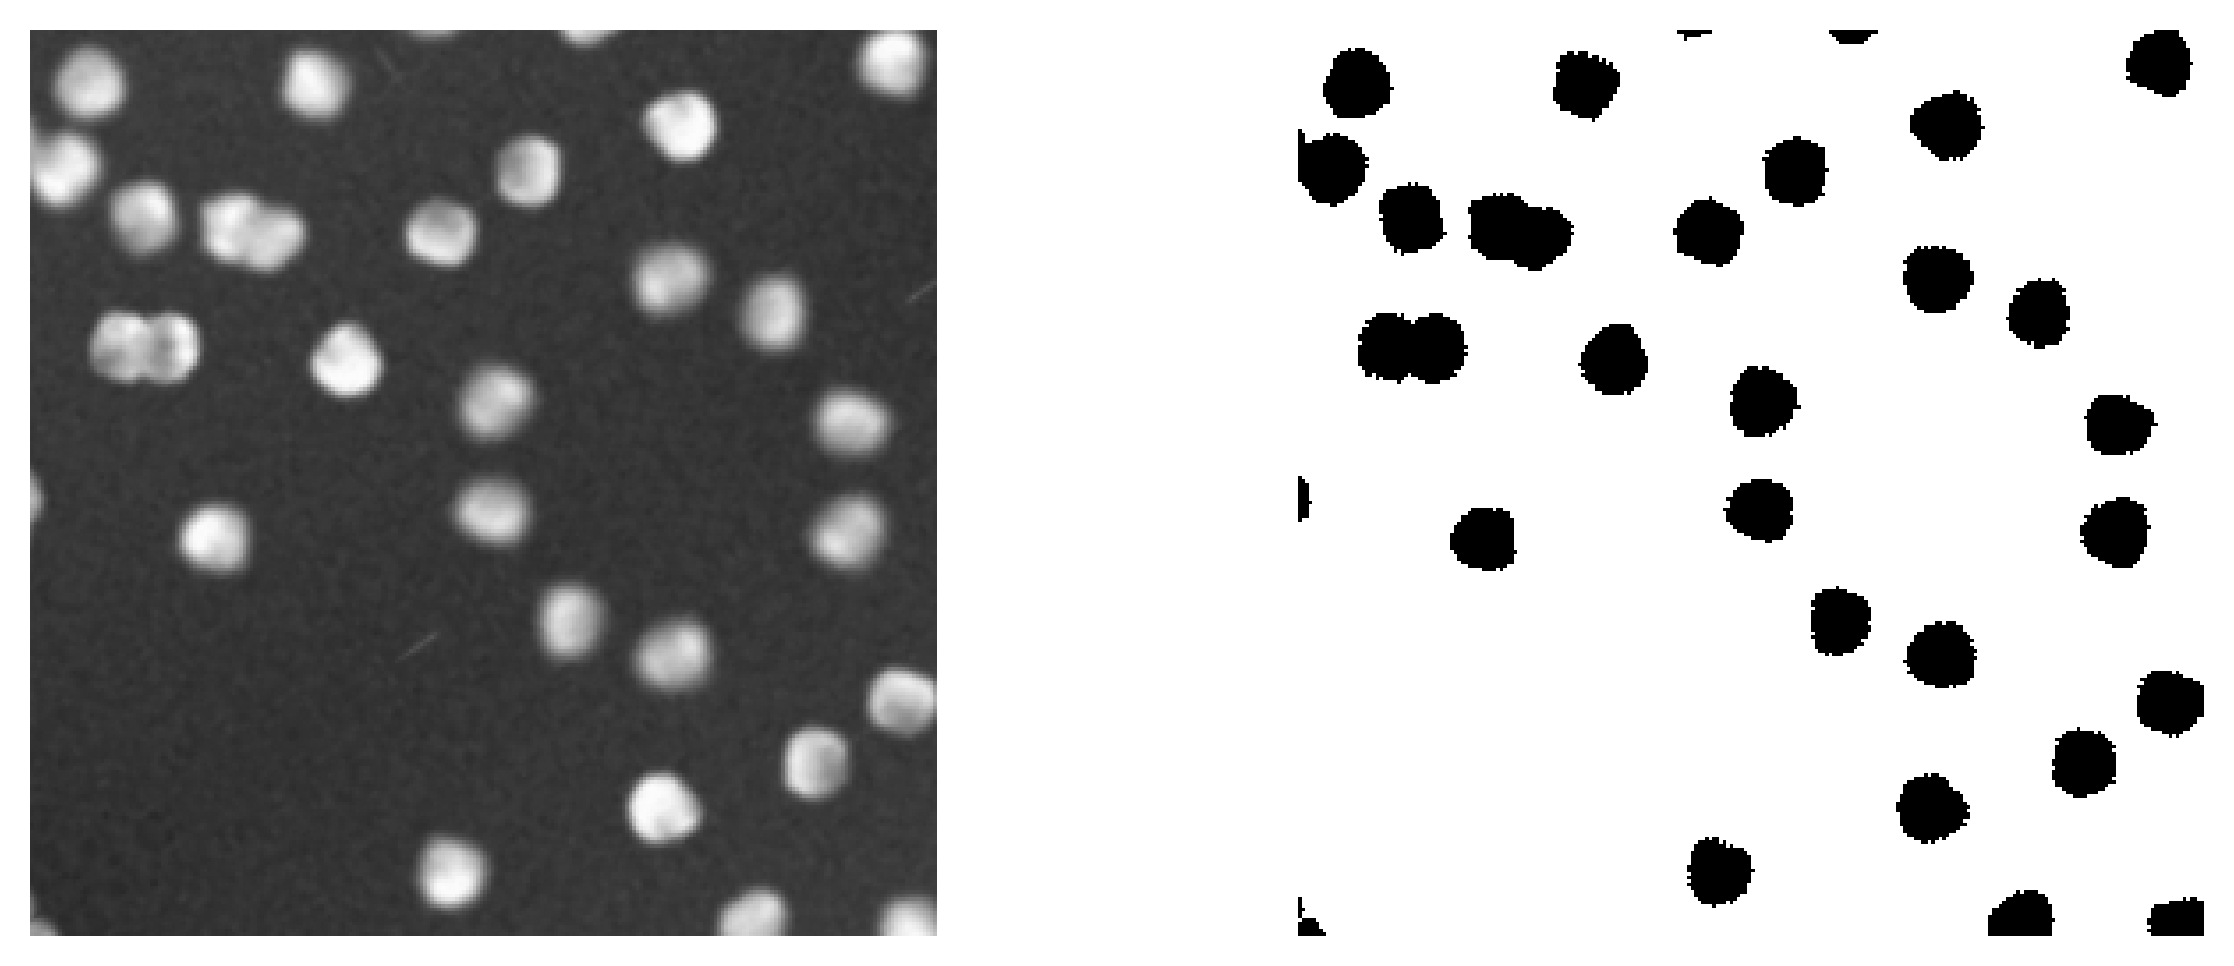

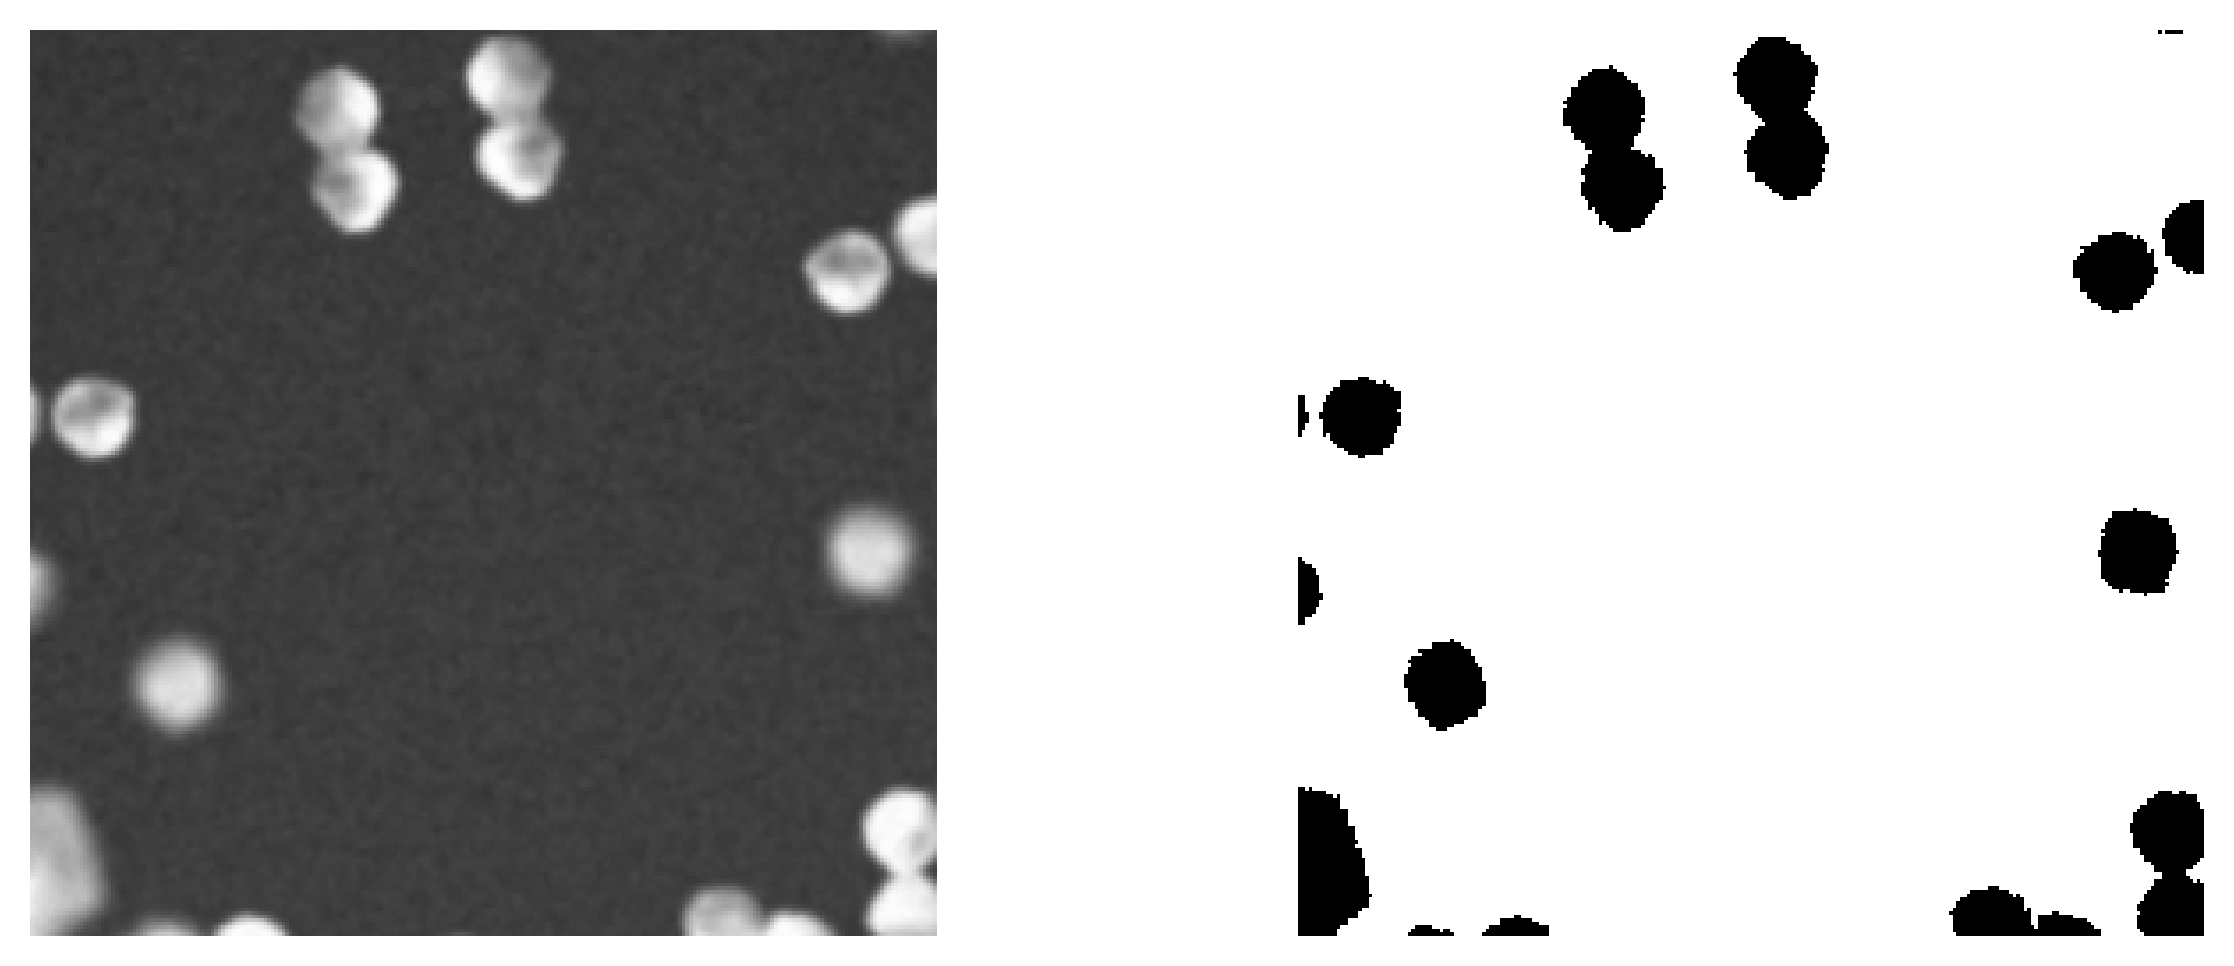

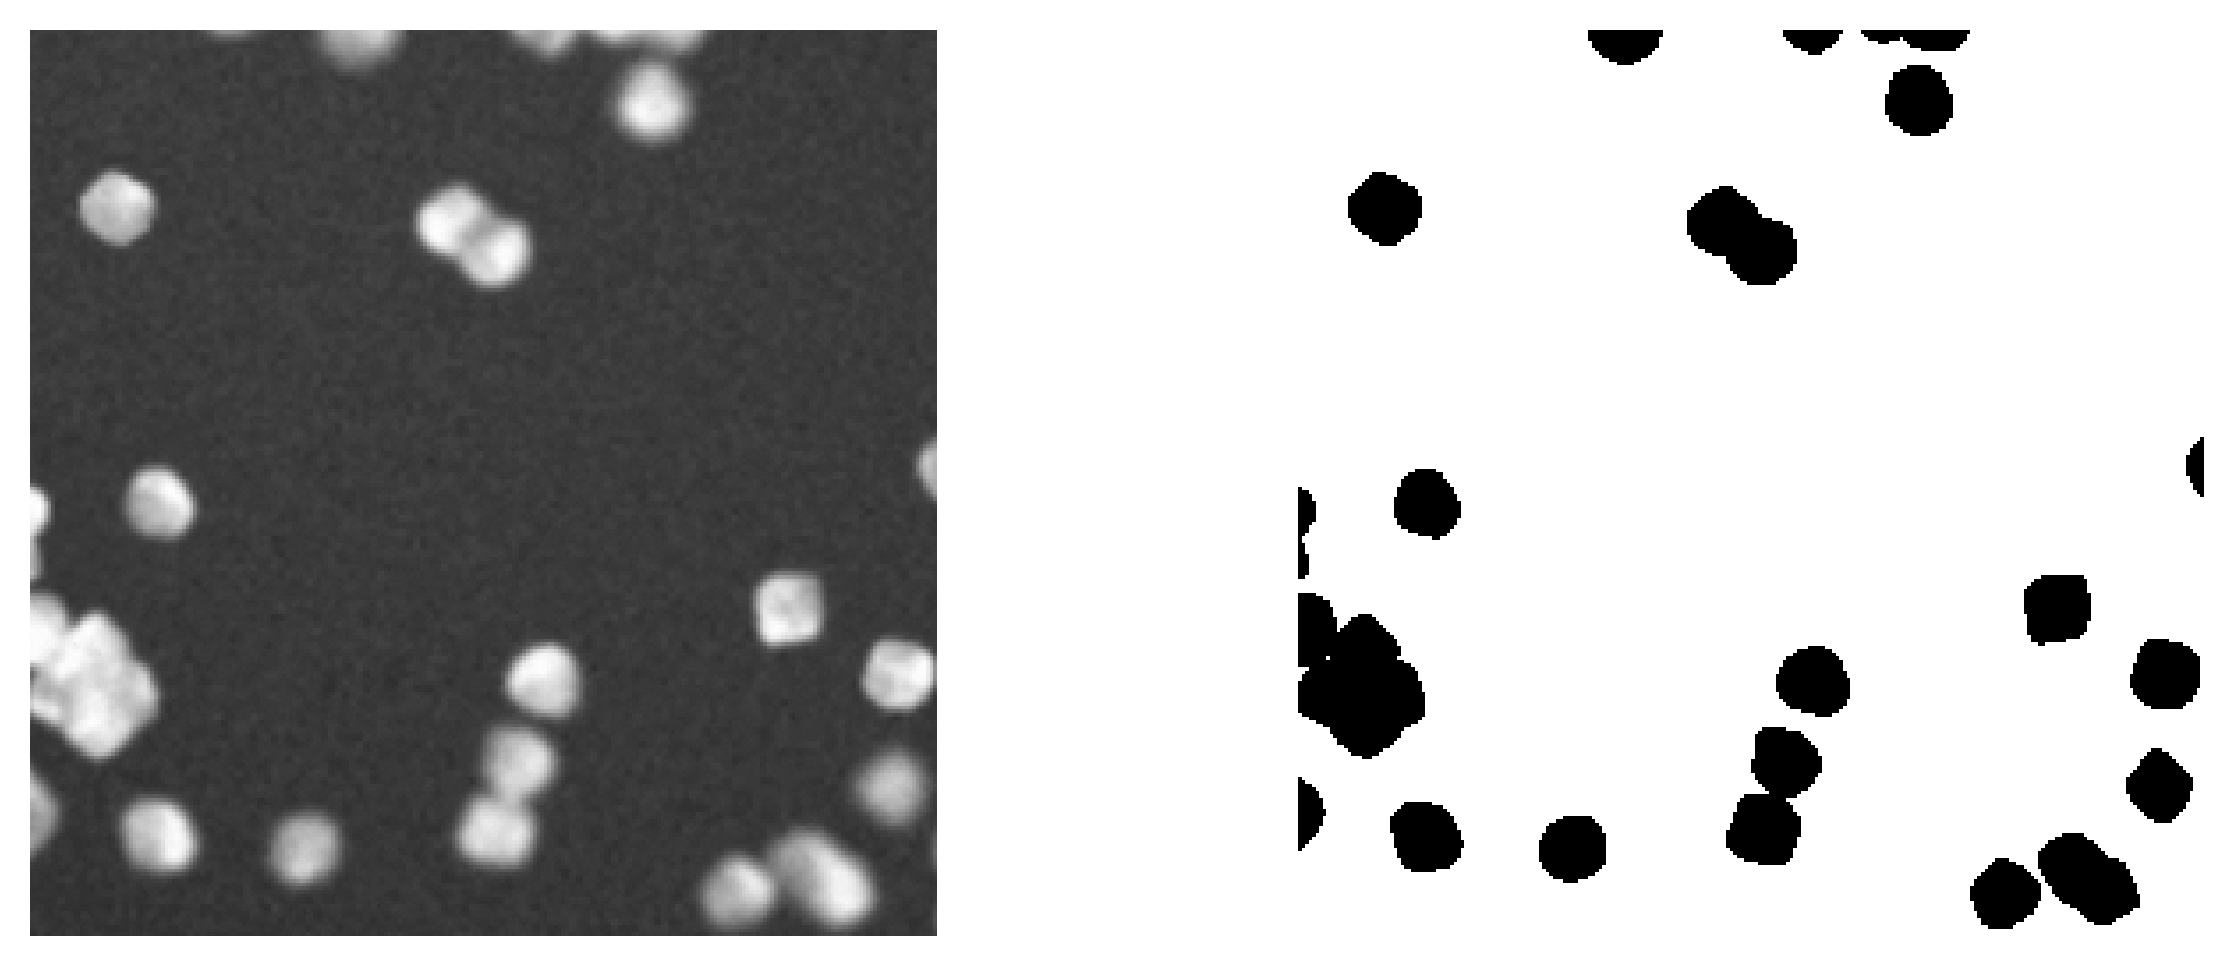

In [9]:
for j in np.random.randint(16, size=3):
    plt.figure(dpi=300, figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(imgs[j], cmap='Greys')
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(masks[j, ..., 0], cmap='Greys')

# Neural network architecture

In [80]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout, UpSampling2D, MaxPooling2D, Activation
from keras.layers import Conv2D

In [81]:
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

In [82]:
base_out

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [83]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [84]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block3_out').output
conv3 = base_model.get_layer('conv3_block4_out').output
conv4 = base_model.get_layer('conv4_block6_out').output
conv5 = base_model.get_layer('conv5_block3_out').output

In [85]:
print(conv1.shape)
print(conv2.shape)
print(conv3.shape)
print(conv4.shape)
print(conv5.shape)

(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 16, 16, 1024)
(None, 8, 8, 2048)


In [86]:
inp = base_model.get_layer(base_model.layers[0].name).output

In [87]:
inp

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>

In [88]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)

In [89]:
conv_conc_5

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'activation_19')>

In [90]:
model = Model(base_model.input, conv_conc_5)

# Neural network training

In [92]:
best_w = keras.callbacks.ModelCheckpoint(
    'unet_best.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

last_w = keras.callbacks.ModelCheckpoint(
    'unet_last.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)


callbacks = [best_w, last_w]

lr_scheduler = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    end_learning_rate=0.000001,
    power=1.0,
    cycle=True
)

adam = keras.optimizers.Adam(lr_scheduler)

model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
batch_size = 16
history = model.fit(
    batch_generator(X_train, Y_train, batch_size),
    steps_per_epoch=100,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=batch_generator(X_test, Y_test, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/100
100/100 [==============================] - 64s 591ms/step - loss: 0.7481 - accuracy: 0.9341 - val_loss: 0.9468 - val_accuracy: 0.9011
Epoch 2/100
100/100 [==============================] - 58s 579ms/step - loss: 0.0152 - accuracy: 0.9937 - val_loss: 1.1918 - val_accuracy: 0.9009
Epoch 3/100
100/100 [==============================] - 58s 581ms/step - loss: 0.0139 - accuracy: 0.9942 - val_loss: 1.2351 - val_accuracy: 0.8984
Epoch 4/100
100/100 [==============================] - 59s 590ms/step - loss: 0.0122 - accuracy: 0.9949 - val_loss: 1.2811 - val_accuracy: 0.9001
Epoch 5/100
100/100 [==============================] - 58s 581ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 1.0515 - val_accuracy: 0.9021
Epoch 6/100
100/100 [==============================] - 58s 585ms/step - loss: 0.0120 - accuracy: 0.9950 - val_loss: 0.9151 - val_accuracy: 0.9023
Epoch 7/100
100/100 [==============================] - 58s 587ms/step - loss: 0.0120 - accuracy: 0.9950 - val_loss: 0.7309 -

KeyboardInterrupt: ignored

# Training results

In [124]:
history = model.fit(
    batch_generator(X_train, Y_train, batch_size),
    steps_per_epoch=100,
    epochs=1,
    verbose=1,
    callbacks=callbacks,
    validation_data=batch_generator(X_test, Y_test, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)

100/100 [==============================] - 59s 590ms/step - loss: 0.0104 - accuracy: 0.9957 - val_loss: 0.0105 - val_accuracy: 0.9957


In [129]:
history.history['val_accuracy']

[0.9956632852554321]

In [130]:
rand_num = np.random.randint(X_test.size)
img, mask = next(batch_generator(X_test, Y_test, 5))

In [131]:
img.shape, mask.shape

((5, 256, 256, 3), (5, 256, 256, 1))

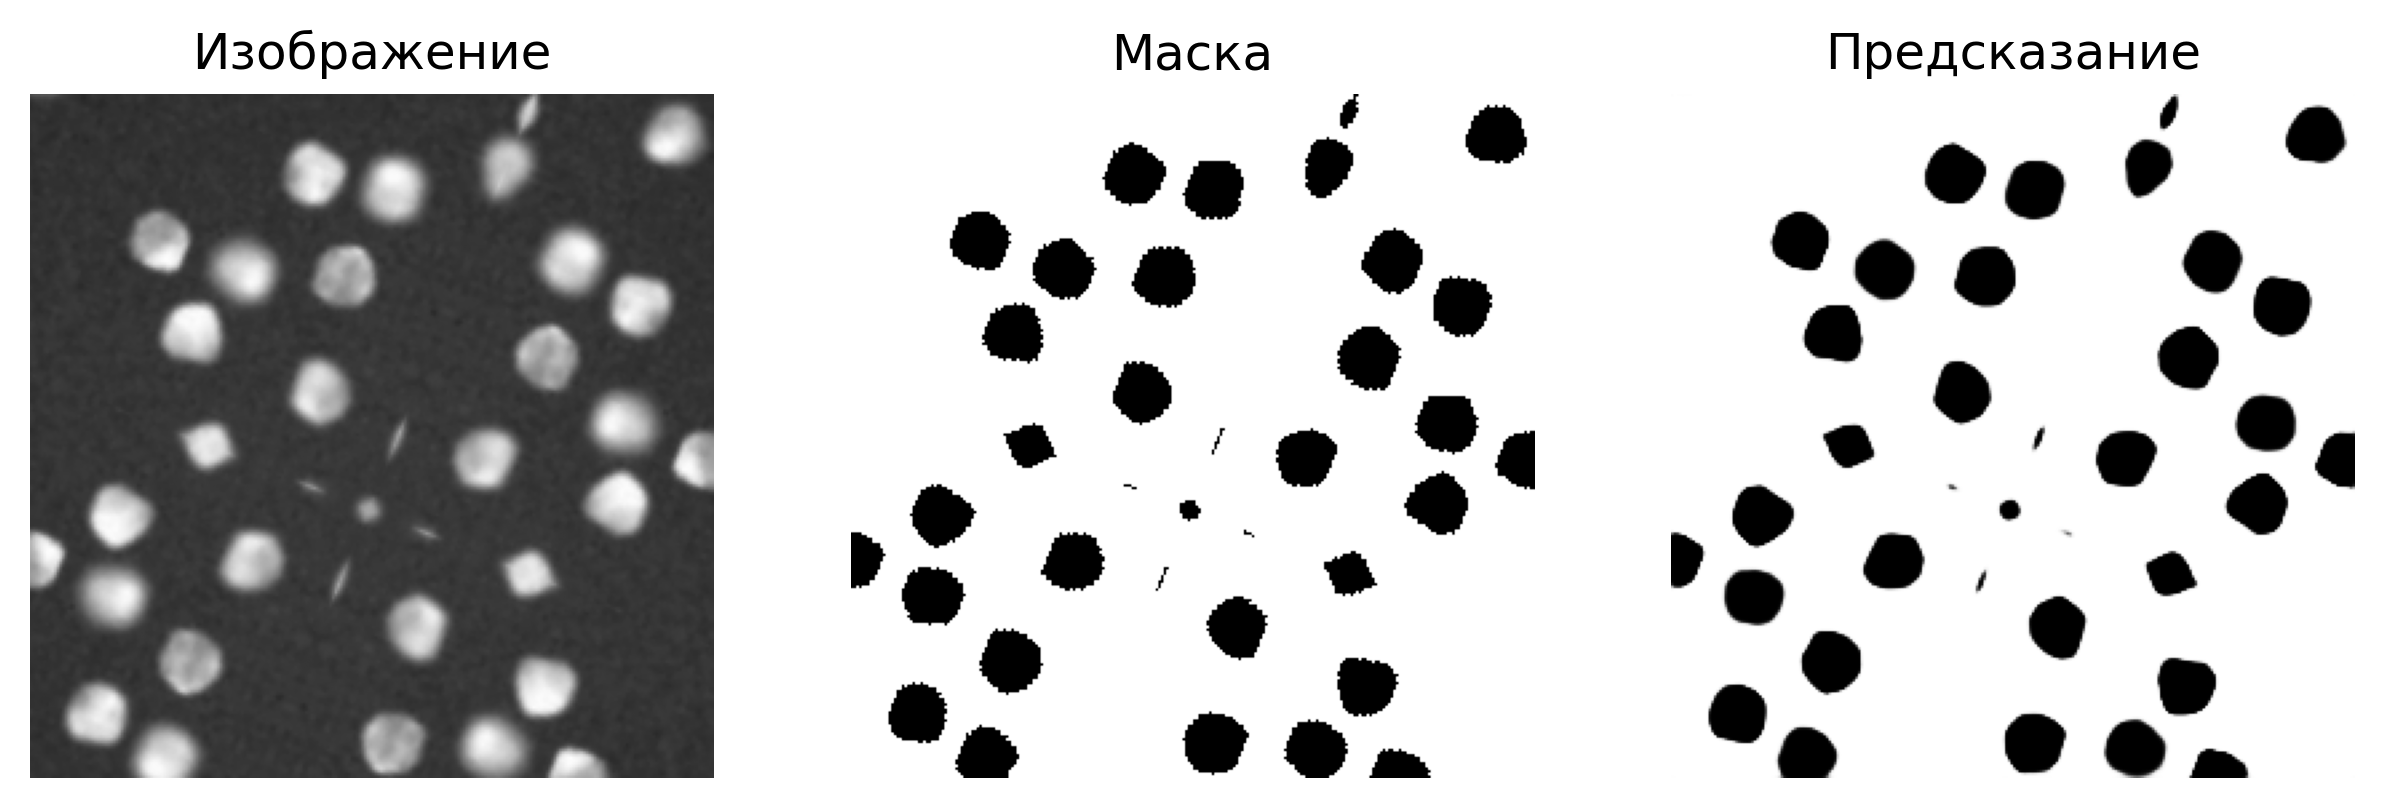

In [133]:
plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(img[0], cmap='Greys')
plt.subplot(1, 3, 2)
plt.title('Маска')
plt.axis('off')
plt.imshow(mask[0][..., 0], cmap='Greys')
plt.subplot(1, 3, 3)
plt.title('Предсказание')
plt.axis('off')
plt.imshow(
    # np.around(
        model.predict(img)[0][..., 0]
        # )
    , 
        cmap='Greys')

# Testing on initial images

In [229]:
init_img = cv.imread('/content/drive/MyDrive/Физтех/ООП проект/Эмбриологические_снимки/image0013.tif')
init_img = cv.cvtColor(init_img, cv.COLOR_BGR2RGB)

In [230]:
init_img.shape

(1440, 1920, 3)

In [232]:
def cropped_img(img, threshold=0):
    threshold = np.argwhere(img[..., 0] > threshold)
    (ystart, xstart), (ystop, xstop) = threshold.min(0), threshold.max(0) + 1 
    return img[ystart:ystop, xstart:xstop, ...]

In [233]:
crp_img = cropped_img(init_img, threshold=130)

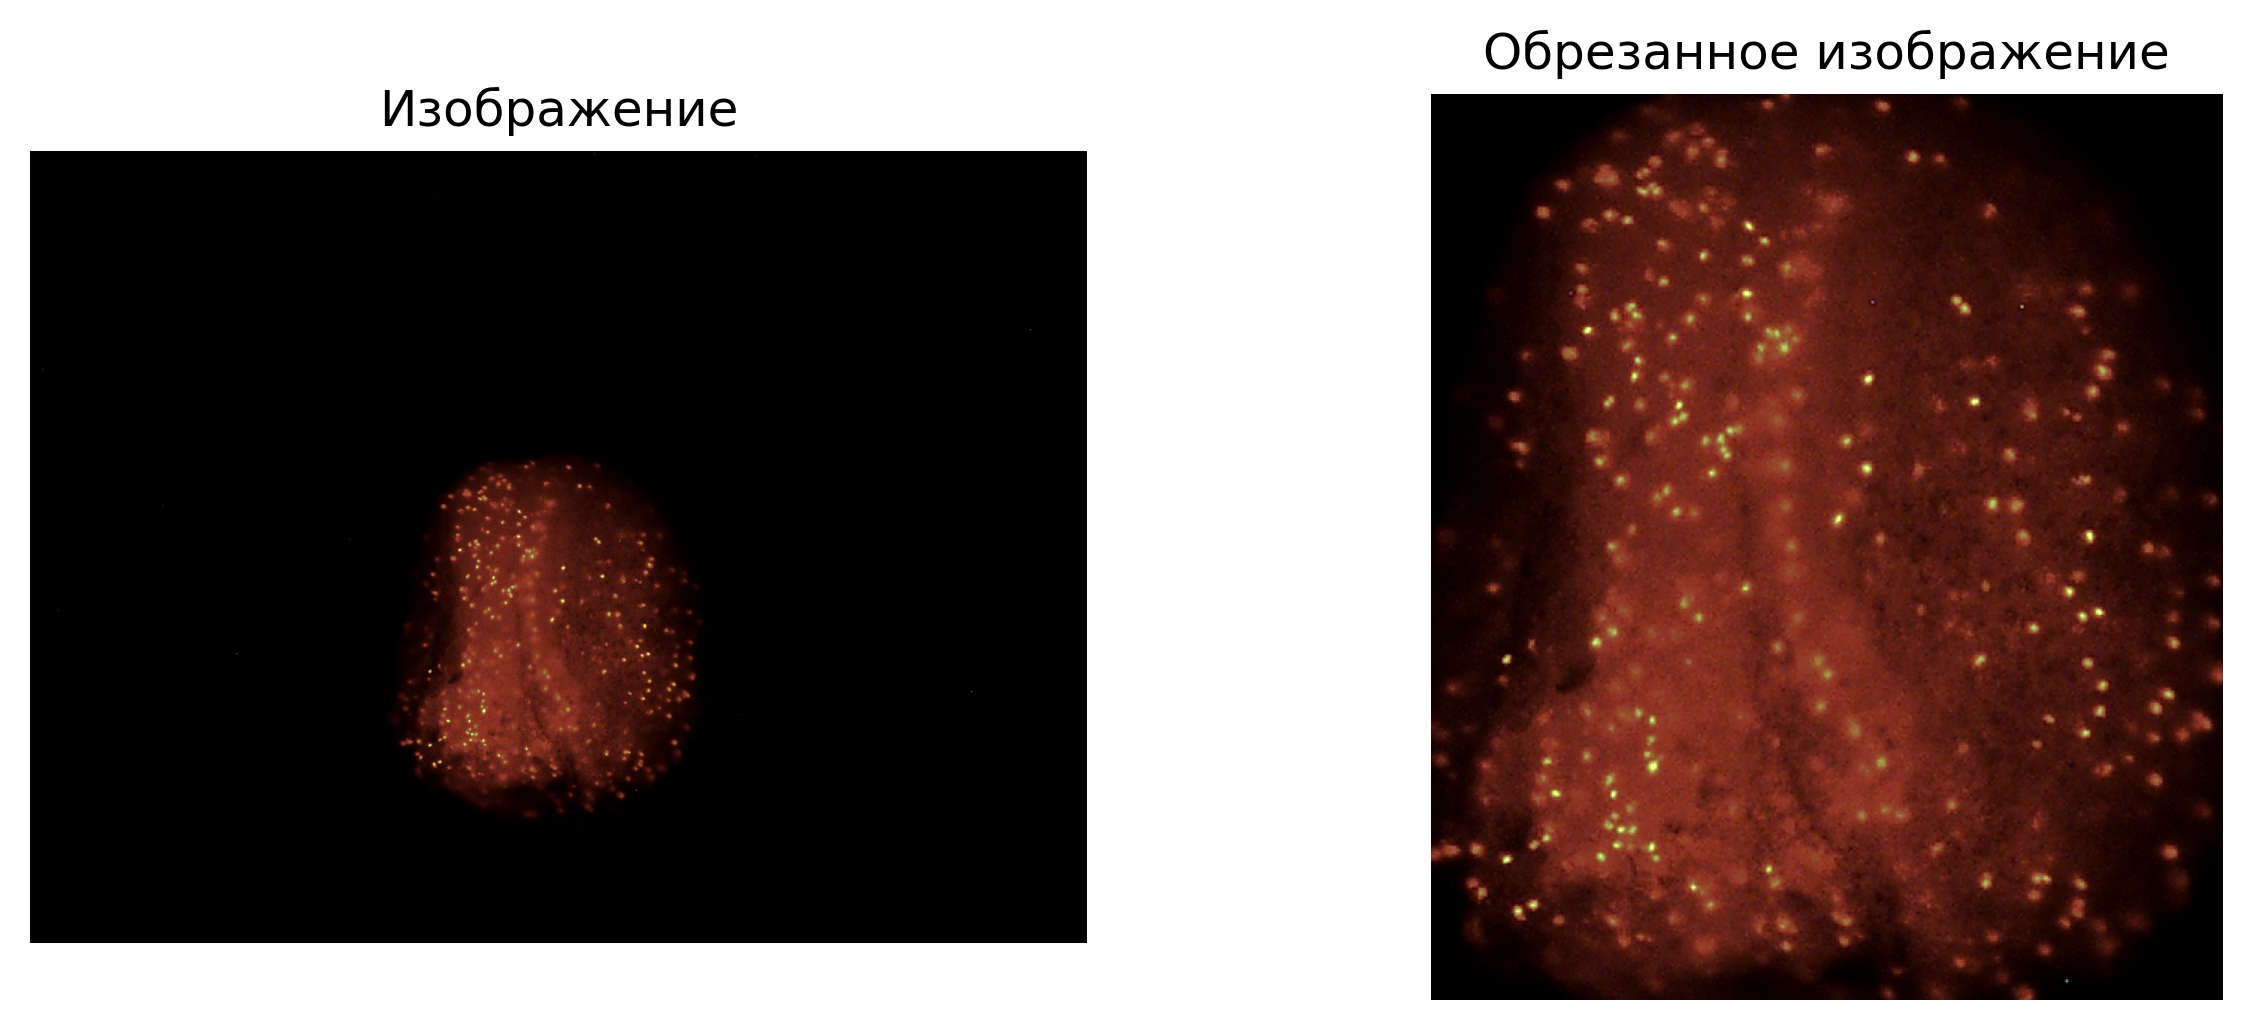

In [234]:
plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(init_img, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title('Обрезанное изображение')
plt.axis('off')
plt.imshow(crp_img, cmap='Greys')

In [235]:
crp_img = cv.resize(crp_img, (256, 256)) / 255

In [236]:
crp_img.shape

(256, 256, 3)

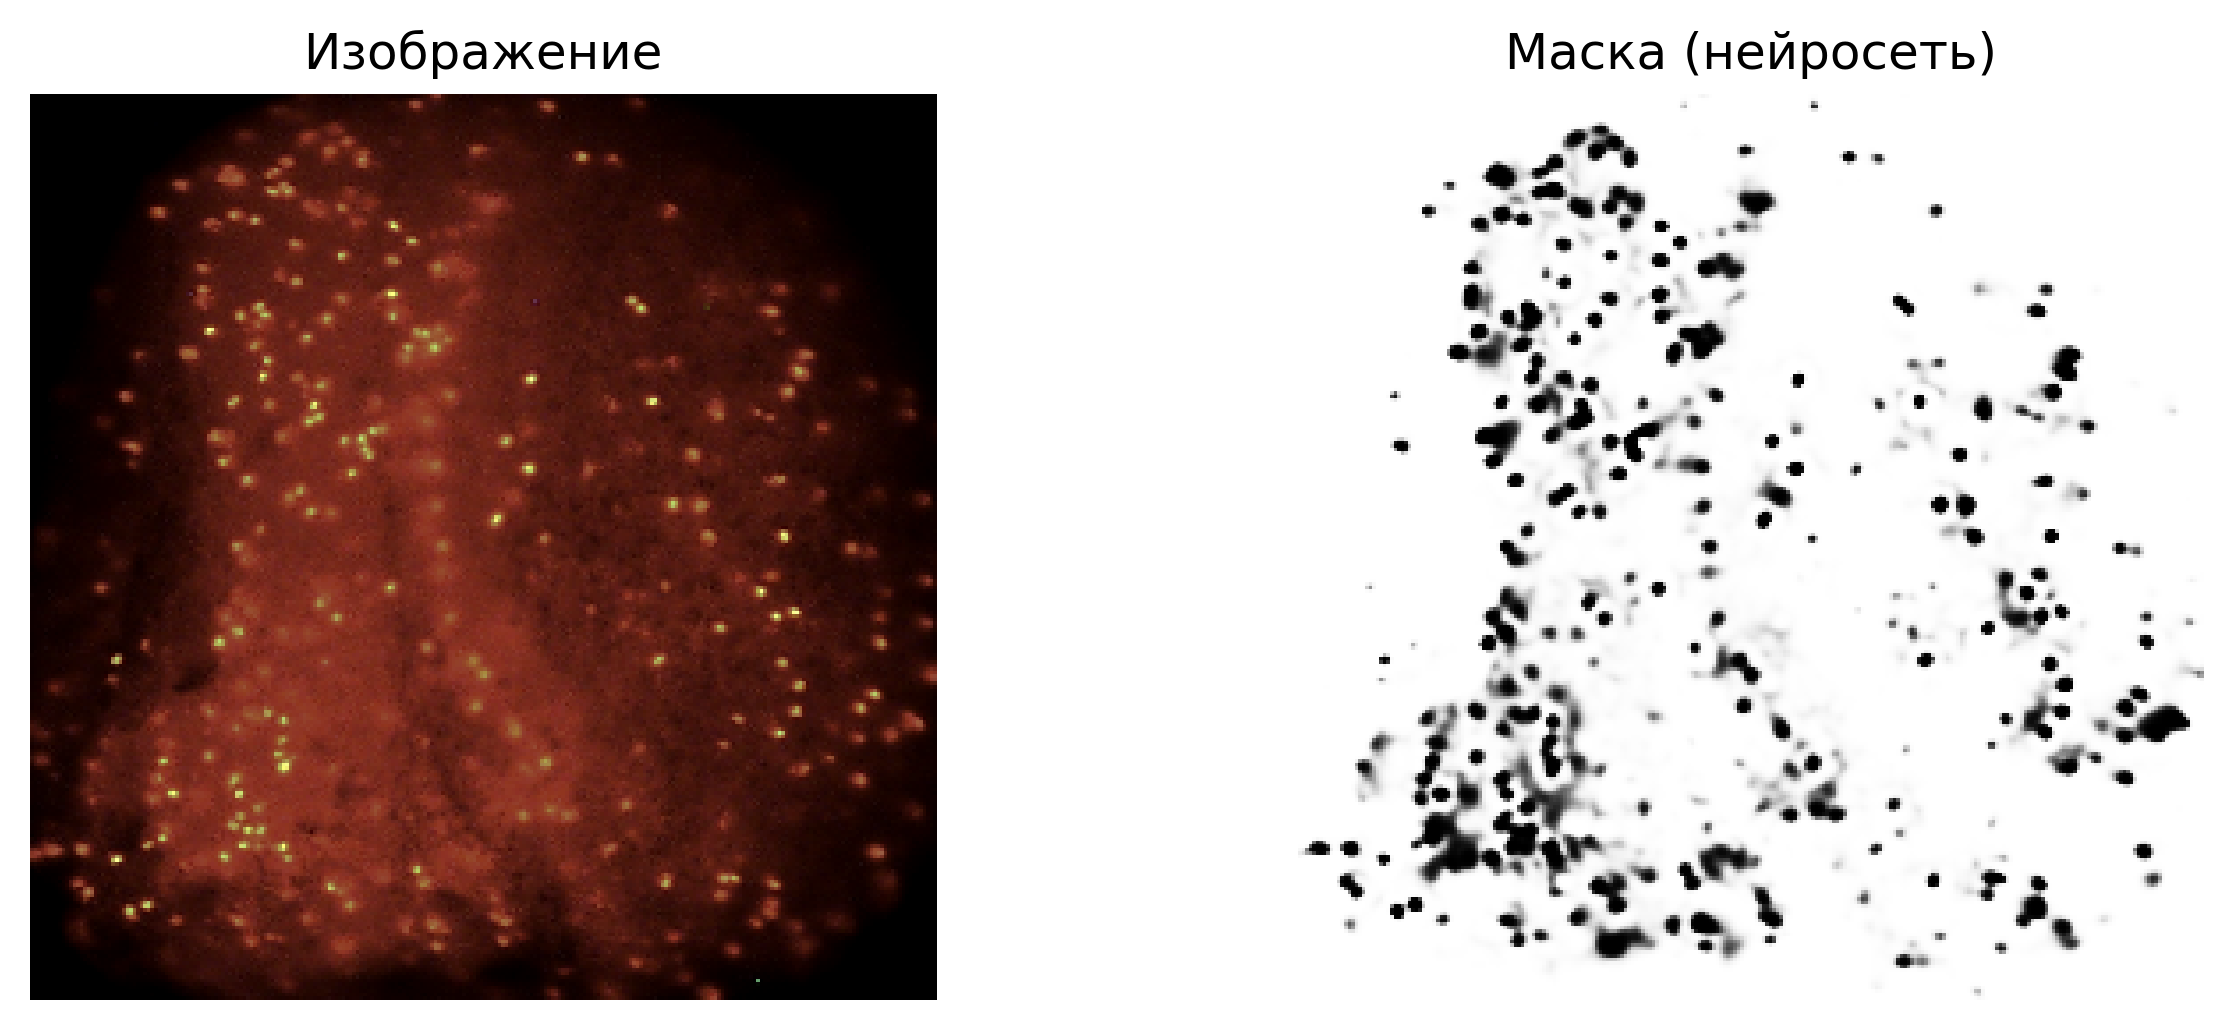

In [237]:
plt.figure(dpi=300, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Изображение')
plt.axis('off')
plt.imshow(crp_img, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title('Маска (нейросеть)')
plt.axis('off')
plt.imshow(model.predict(np.expand_dims(crp_img, 0))[0][..., 0], cmap='Greys')